# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:14 - loss: 0.6925

  23/1875 [..............................] - ETA: 4s - loss: 0.5737   

  46/1875 [..............................] - ETA: 4s - loss: 0.4919

  69/1875 [>.............................] - ETA: 4s - loss: 0.4472

  96/1875 [>.............................] - ETA: 3s - loss: 0.4141

 119/1875 [>.............................] - ETA: 3s - loss: 0.3944

 142/1875 [=>............................] - ETA: 3s - loss: 0.3789

 165/1875 [=>............................] - ETA: 3s - loss: 0.3664

 190/1875 [==>...........................] - ETA: 3s - loss: 0.3549

 214/1875 [==>...........................] - ETA: 3s - loss: 0.3454

 239/1875 [==>...........................] - ETA: 3s - loss: 0.3367

 263/1875 [===>..........................] - ETA: 3s - loss: 0.3293

 287/1875 [===>..........................] - ETA: 3s - loss: 0.3226

 312/1875 [===>..........................] - ETA: 3s - loss: 0.3164

 337/1875 [====>.........................] - ETA: 3s - loss: 0.3106

 363/1875 [====>.........................] - ETA: 3s - loss: 0.3052

 387/1875 [=====>........................] - ETA: 3s - loss: 0.3005

 412/1875 [=====>........................] - ETA: 3s - loss: 0.2961

 436/1875 [=====>........................] - ETA: 3s - loss: 0.2920

 459/1875 [======>.......................] - ETA: 2s - loss: 0.2884

 484/1875 [======>.......................] - ETA: 2s - loss: 0.2847

 502/1875 [=======>......................] - ETA: 2s - loss: 0.2822

 526/1875 [=======>......................] - ETA: 2s - loss: 0.2790

 551/1875 [=======>......................] - ETA: 2s - loss: 0.2758

 577/1875 [========>.....................] - ETA: 2s - loss: 0.2727

 598/1875 [========>.....................] - ETA: 2s - loss: 0.2703

 623/1875 [========>.....................] - ETA: 2s - loss: 0.2676

 648/1875 [=========>....................] - ETA: 2s - loss: 0.2650

 673/1875 [=========>....................] - ETA: 2s - loss: 0.2625

 697/1875 [==========>...................] - ETA: 2s - loss: 0.2602

 722/1875 [==========>...................] - ETA: 2s - loss: 0.2580

 747/1875 [==========>...................] - ETA: 2s - loss: 0.2558

 767/1875 [===========>..................] - ETA: 2s - loss: 0.2541

 792/1875 [===========>..................] - ETA: 2s - loss: 0.2521

 817/1875 [============>.................] - ETA: 2s - loss: 0.2501

 840/1875 [============>.................] - ETA: 2s - loss: 0.2483

 863/1875 [============>.................] - ETA: 2s - loss: 0.2467

 884/1875 [=============>................] - ETA: 2s - loss: 0.2452

 907/1875 [=============>................] - ETA: 2s - loss: 0.2436

 927/1875 [=============>................] - ETA: 2s - loss: 0.2422

 949/1875 [==============>...............] - ETA: 1s - loss: 0.2408

 976/1875 [==============>...............] - ETA: 1s - loss: 0.2391

1002/1875 [===============>..............] - ETA: 1s - loss: 0.2375

1031/1875 [===============>..............] - ETA: 1s - loss: 0.2358

1061/1875 [===============>..............] - ETA: 1s - loss: 0.2340

1086/1875 [================>.............] - ETA: 1s - loss: 0.2327

1111/1875 [================>.............] - ETA: 1s - loss: 0.2313

1136/1875 [=================>............] - ETA: 1s - loss: 0.2300

1161/1875 [=================>............] - ETA: 1s - loss: 0.2287

1186/1875 [=================>............] - ETA: 1s - loss: 0.2275

1202/1875 [==================>...........] - ETA: 1s - loss: 0.2267

1215/1875 [==================>...........] - ETA: 1s - loss: 0.2261

1235/1875 [==================>...........] - ETA: 1s - loss: 0.2251

1256/1875 [===================>..........] - ETA: 1s - loss: 0.2241

1281/1875 [===================>..........] - ETA: 1s - loss: 0.2230

1308/1875 [===================>..........] - ETA: 1s - loss: 0.2218

1333/1875 [====================>.........] - ETA: 1s - loss: 0.2207

1360/1875 [====================>.........] - ETA: 1s - loss: 0.2196

1385/1875 [=====================>........] - ETA: 1s - loss: 0.2186

1410/1875 [=====================>........] - ETA: 0s - loss: 0.2176

1433/1875 [=====================>........] - ETA: 0s - loss: 0.2167

1459/1875 [======================>.......] - ETA: 0s - loss: 0.2157

1485/1875 [======================>.......] - ETA: 0s - loss: 0.2147

1511/1875 [=======================>......] - ETA: 0s - loss: 0.2137

1537/1875 [=======================>......] - ETA: 0s - loss: 0.2128

1564/1875 [========================>.....] - ETA: 0s - loss: 0.2118

1583/1875 [========================>.....] - ETA: 0s - loss: 0.2112

1607/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1631/1875 [=========================>....] - ETA: 0s - loss: 0.2095

1654/1875 [=========================>....] - ETA: 0s - loss: 0.2088

1679/1875 [=========================>....] - ETA: 0s - loss: 0.2080

1703/1875 [==========================>...] - ETA: 0s - loss: 0.2072

1727/1875 [==========================>...] - ETA: 0s - loss: 0.2064

1751/1875 [===========================>..] - ETA: 0s - loss: 0.2057

1776/1875 [===========================>..] - ETA: 0s - loss: 0.2050

1798/1875 [===========================>..] - ETA: 0s - loss: 0.2043

1820/1875 [============================>.] - ETA: 0s - loss: 0.2037

1844/1875 [============================>.] - ETA: 0s - loss: 0.2030

1868/1875 [============================>.] - ETA: 0s - loss: 0.2023

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2021


Epoch 2/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1095

  24/1875 [..............................] - ETA: 4s - loss: 0.1070

  40/1875 [..............................] - ETA: 5s - loss: 0.1072

  57/1875 [..............................] - ETA: 5s - loss: 0.1072

  77/1875 [>.............................] - ETA: 4s - loss: 0.1072

 103/1875 [>.............................] - ETA: 4s - loss: 0.1071

 129/1875 [=>............................] - ETA: 4s - loss: 0.1071

 154/1875 [=>............................] - ETA: 4s - loss: 0.1071

 176/1875 [=>............................] - ETA: 3s - loss: 0.1072

 202/1875 [==>...........................] - ETA: 3s - loss: 0.1072

 227/1875 [==>...........................] - ETA: 3s - loss: 0.1072

 252/1875 [===>..........................] - ETA: 3s - loss: 0.1072

 278/1875 [===>..........................] - ETA: 3s - loss: 0.1072

 303/1875 [===>..........................] - ETA: 3s - loss: 0.1072

 329/1875 [====>.........................] - ETA: 3s - loss: 0.1072

 354/1875 [====>.........................] - ETA: 3s - loss: 0.1072

 380/1875 [=====>........................] - ETA: 3s - loss: 0.1072

 403/1875 [=====>........................] - ETA: 3s - loss: 0.1071

 428/1875 [=====>........................] - ETA: 3s - loss: 0.1071

 451/1875 [======>.......................] - ETA: 3s - loss: 0.1071

 472/1875 [======>.......................] - ETA: 3s - loss: 0.1071

 498/1875 [======>.......................] - ETA: 2s - loss: 0.1071

 519/1875 [=======>......................] - ETA: 2s - loss: 0.1071

 545/1875 [=======>......................] - ETA: 2s - loss: 0.1071

 572/1875 [========>.....................] - ETA: 2s - loss: 0.1070

 598/1875 [========>.....................] - ETA: 2s - loss: 0.1070

 624/1875 [========>.....................] - ETA: 2s - loss: 0.1070

 650/1875 [=========>....................] - ETA: 2s - loss: 0.1069

 675/1875 [=========>....................] - ETA: 2s - loss: 0.1069

 701/1875 [==========>...................] - ETA: 2s - loss: 0.1069

 726/1875 [==========>...................] - ETA: 2s - loss: 0.1068

 753/1875 [===========>..................] - ETA: 2s - loss: 0.1068

 780/1875 [===========>..................] - ETA: 2s - loss: 0.1068

 806/1875 [===========>..................] - ETA: 2s - loss: 0.1067

 832/1875 [============>.................] - ETA: 2s - loss: 0.1067

 858/1875 [============>.................] - ETA: 2s - loss: 0.1066

 884/1875 [=============>................] - ETA: 2s - loss: 0.1066

 910/1875 [=============>................] - ETA: 2s - loss: 0.1066

 936/1875 [=============>................] - ETA: 1s - loss: 0.1065

 961/1875 [==============>...............] - ETA: 1s - loss: 0.1065

 982/1875 [==============>...............] - ETA: 1s - loss: 0.1064

1007/1875 [===============>..............] - ETA: 1s - loss: 0.1064

1033/1875 [===============>..............] - ETA: 1s - loss: 0.1064

1059/1875 [===============>..............] - ETA: 1s - loss: 0.1063

1084/1875 [================>.............] - ETA: 1s - loss: 0.1063

1109/1875 [================>.............] - ETA: 1s - loss: 0.1062

1130/1875 [=================>............] - ETA: 1s - loss: 0.1062

1155/1875 [=================>............] - ETA: 1s - loss: 0.1062

1180/1875 [=================>............] - ETA: 1s - loss: 0.1061

1205/1875 [==================>...........] - ETA: 1s - loss: 0.1061

1230/1875 [==================>...........] - ETA: 1s - loss: 0.1061

1258/1875 [===================>..........] - ETA: 1s - loss: 0.1060

1282/1875 [===================>..........] - ETA: 1s - loss: 0.1060

1306/1875 [===================>..........] - ETA: 1s - loss: 0.1059

1331/1875 [====================>.........] - ETA: 1s - loss: 0.1059

1356/1875 [====================>.........] - ETA: 1s - loss: 0.1059

1381/1875 [=====================>........] - ETA: 1s - loss: 0.1058

1406/1875 [=====================>........] - ETA: 0s - loss: 0.1058

1431/1875 [=====================>........] - ETA: 0s - loss: 0.1058

1456/1875 [======================>.......] - ETA: 0s - loss: 0.1057

1481/1875 [======================>.......] - ETA: 0s - loss: 0.1057

1506/1875 [=======================>......] - ETA: 0s - loss: 0.1057

1528/1875 [=======================>......] - ETA: 0s - loss: 0.1056

1553/1875 [=======================>......] - ETA: 0s - loss: 0.1056

1580/1875 [========================>.....] - ETA: 0s - loss: 0.1055

1606/1875 [========================>.....] - ETA: 0s - loss: 0.1055

1632/1875 [=========================>....] - ETA: 0s - loss: 0.1055

1654/1875 [=========================>....] - ETA: 0s - loss: 0.1054

1679/1875 [=========================>....] - ETA: 0s - loss: 0.1054

1704/1875 [==========================>...] - ETA: 0s - loss: 0.1054

1728/1875 [==========================>...] - ETA: 0s - loss: 0.1053

1754/1875 [===========================>..] - ETA: 0s - loss: 0.1053

1780/1875 [===========================>..] - ETA: 0s - loss: 0.1053

1807/1875 [===========================>..] - ETA: 0s - loss: 0.1052

1833/1875 [============================>.] - ETA: 0s - loss: 0.1052

1856/1875 [============================>.] - ETA: 0s - loss: 0.1052

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1051


Epoch 3/5
   1/1875 [..............................] - ETA: 7s - loss: 0.1005

  23/1875 [..............................] - ETA: 4s - loss: 0.1008

  48/1875 [..............................] - ETA: 3s - loss: 0.0997

  68/1875 [>.............................] - ETA: 4s - loss: 0.0992

  88/1875 [>.............................] - ETA: 4s - loss: 0.0990

 114/1875 [>.............................] - ETA: 3s - loss: 0.0988

 140/1875 [=>............................] - ETA: 3s - loss: 0.0987

 166/1875 [=>............................] - ETA: 3s - loss: 0.0986

 192/1875 [==>...........................] - ETA: 3s - loss: 0.0985

 217/1875 [==>...........................] - ETA: 3s - loss: 0.0985

 242/1875 [==>...........................] - ETA: 3s - loss: 0.0985

 265/1875 [===>..........................] - ETA: 3s - loss: 0.0984

 290/1875 [===>..........................] - ETA: 3s - loss: 0.0984

 312/1875 [===>..........................] - ETA: 3s - loss: 0.0984

 337/1875 [====>.........................] - ETA: 3s - loss: 0.0984

 362/1875 [====>.........................] - ETA: 3s - loss: 0.0983

 388/1875 [=====>........................] - ETA: 3s - loss: 0.0983

 414/1875 [=====>........................] - ETA: 3s - loss: 0.0983

 439/1875 [======>.......................] - ETA: 3s - loss: 0.0982

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 488/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 537/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 562/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 587/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 613/1875 [========>.....................] - ETA: 2s - loss: 0.0981

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0981

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0981

 688/1875 [==========>...................] - ETA: 2s - loss: 0.0981

 714/1875 [==========>...................] - ETA: 2s - loss: 0.0981

 739/1875 [==========>...................] - ETA: 2s - loss: 0.0981

 763/1875 [===========>..................] - ETA: 2s - loss: 0.0981

 788/1875 [===========>..................] - ETA: 2s - loss: 0.0981

 813/1875 [============>.................] - ETA: 2s - loss: 0.0980

 838/1875 [============>.................] - ETA: 2s - loss: 0.0980

 864/1875 [============>.................] - ETA: 2s - loss: 0.0980

 889/1875 [=============>................] - ETA: 2s - loss: 0.0980

 914/1875 [=============>................] - ETA: 1s - loss: 0.0980

 940/1875 [==============>...............] - ETA: 1s - loss: 0.0980

 967/1875 [==============>...............] - ETA: 1s - loss: 0.0980

 993/1875 [==============>...............] - ETA: 1s - loss: 0.0980

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1071/1875 [================>.............] - ETA: 1s - loss: 0.0979

1093/1875 [================>.............] - ETA: 1s - loss: 0.0979

1114/1875 [================>.............] - ETA: 1s - loss: 0.0979

1140/1875 [=================>............] - ETA: 1s - loss: 0.0979

1166/1875 [=================>............] - ETA: 1s - loss: 0.0979



1198/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1227/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1278/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1302/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1329/1875 [====================>.........] - ETA: 1s - loss: 0.0978

1359/1875 [====================>.........] - ETA: 1s - loss: 0.0978

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1419/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1537/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1566/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1594/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1842/1875 [============================>.] - ETA: 0s - loss: 0.0976

1875/1875 [==============================] - ETA: 0s - loss: 0.0976

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0976


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0906

  35/1875 [..............................] - ETA: 2s - loss: 0.0971

  69/1875 [>.............................] - ETA: 2s - loss: 0.0965

 104/1875 [>.............................] - ETA: 2s - loss: 0.0963

 138/1875 [=>............................] - ETA: 2s - loss: 0.0962

 173/1875 [=>............................] - ETA: 2s - loss: 0.0962

 208/1875 [==>...........................] - ETA: 2s - loss: 0.0962

 241/1875 [==>...........................] - ETA: 2s - loss: 0.0962

 276/1875 [===>..........................] - ETA: 2s - loss: 0.0962

 311/1875 [===>..........................] - ETA: 2s - loss: 0.0962

 346/1875 [====>.........................] - ETA: 2s - loss: 0.0962

 380/1875 [=====>........................] - ETA: 2s - loss: 0.0962

 415/1875 [=====>........................] - ETA: 2s - loss: 0.0962

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 487/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 520/1875 [=======>......................] - ETA: 1s - loss: 0.0962

 555/1875 [=======>......................] - ETA: 1s - loss: 0.0962

 589/1875 [========>.....................] - ETA: 1s - loss: 0.0962

 622/1875 [========>.....................] - ETA: 1s - loss: 0.0962

 656/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 692/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 726/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 756/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 791/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 825/1875 [============>.................] - ETA: 1s - loss: 0.0962

 860/1875 [============>.................] - ETA: 1s - loss: 0.0962

 895/1875 [=============>................] - ETA: 1s - loss: 0.0962

 931/1875 [=============>................] - ETA: 1s - loss: 0.0962

 965/1875 [==============>...............] - ETA: 1s - loss: 0.0962

 997/1875 [==============>...............] - ETA: 1s - loss: 0.0962

1032/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1067/1875 [================>.............] - ETA: 1s - loss: 0.0962

1102/1875 [================>.............] - ETA: 1s - loss: 0.0962

1132/1875 [=================>............] - ETA: 1s - loss: 0.0962

1162/1875 [=================>............] - ETA: 1s - loss: 0.0962

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1234/1875 [==================>...........] - ETA: 0s - loss: 0.0961

1271/1875 [===================>..........] - ETA: 0s - loss: 0.0961

1306/1875 [===================>..........] - ETA: 0s - loss: 0.0961

1341/1875 [====================>.........] - ETA: 0s - loss: 0.0961

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1449/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1484/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1822/1875 [============================>.] - ETA: 0s - loss: 0.0961

1856/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0961


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0914

  36/1875 [..............................] - ETA: 2s - loss: 0.0934

  71/1875 [>.............................] - ETA: 2s - loss: 0.0944

 105/1875 [>.............................] - ETA: 2s - loss: 0.0947

 138/1875 [=>............................] - ETA: 2s - loss: 0.0949

 172/1875 [=>............................] - ETA: 2s - loss: 0.0949

 206/1875 [==>...........................] - ETA: 2s - loss: 0.0949

 240/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 308/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 342/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 376/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 407/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 442/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 477/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 513/1875 [=======>......................] - ETA: 2s - loss: 0.0951

 548/1875 [=======>......................] - ETA: 1s - loss: 0.0951

 583/1875 [========>.....................] - ETA: 1s - loss: 0.0951

 618/1875 [========>.....................] - ETA: 1s - loss: 0.0951

 652/1875 [=========>....................] - ETA: 1s - loss: 0.0951

 685/1875 [=========>....................] - ETA: 1s - loss: 0.0951

 720/1875 [==========>...................] - ETA: 1s - loss: 0.0951

 754/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 788/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 822/1875 [============>.................] - ETA: 1s - loss: 0.0951

 856/1875 [============>.................] - ETA: 1s - loss: 0.0951

 889/1875 [=============>................] - ETA: 1s - loss: 0.0951

 923/1875 [=============>................] - ETA: 1s - loss: 0.0951

 956/1875 [==============>...............] - ETA: 1s - loss: 0.0951

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1057/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1088/1875 [================>.............] - ETA: 1s - loss: 0.0952

1121/1875 [================>.............] - ETA: 1s - loss: 0.0952

1155/1875 [=================>............] - ETA: 1s - loss: 0.0952

1188/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1222/1875 [==================>...........] - ETA: 0s - loss: 0.0952

1255/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1289/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1323/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1357/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1391/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1482/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1514/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1544/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1610/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1712/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1813/1875 [============================>.] - ETA: 0s - loss: 0.0952

1846/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

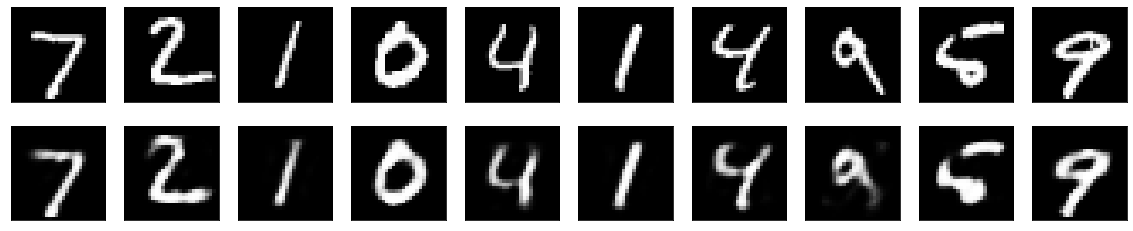

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
